In [1]:
import sys; sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np
import os
from src.simple_utils import load_pickle
from src.data_utils import get_dataset_imagenet, imagenet_classes
from os.path import join

import matplotlib as mpl
import numpy as np
from scipy.interpolate import interp1d
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
import pandas as pd
from p_tqdm import p_map, p_umap # parallel map
from functools import partial
from multiprocessing import RawArray, Pool
pmap = p_map

import PIL
import PIL.Image
from tqdm.auto import tqdm

rng = np.random.default_rng(5)

In [2]:
!ls ../processed/imagenet/resnet50/

locks		     resnet50_imagenet_sketch	   resnet50_imagenet_val
resnet50_imagenet_a  resnet50_imagenet_sketch.npz  resnet50_imagenet_val.npz
resnet50_imagenet_r  resnet50_imagenet_v2


In [5]:
gname = 'resnet50'
dname = 'imagenet_val' # or imagenet_sketch
classes = imagenet_classes

G = np.load(f'../processed/imagenet/resnet50/resnet50_{dname}.npz', mmap_mode='r')
dataset = get_dataset_imagenet(dname)
ytest = dataset.targets

NUM_SAMPLES, NUM_CLASSES, NUM_CHECKPOINTS = G['probs'].shape

In [8]:
list(G.keys())

['x',
 'all_acc',
 'x_err',
 'all_acc_err',
 'points',
 'points_err',
 'labels',
 'labels_err',
 'probs',
 'freqs']

In [7]:
G['probs'].shape

(50000, 1000, 40)

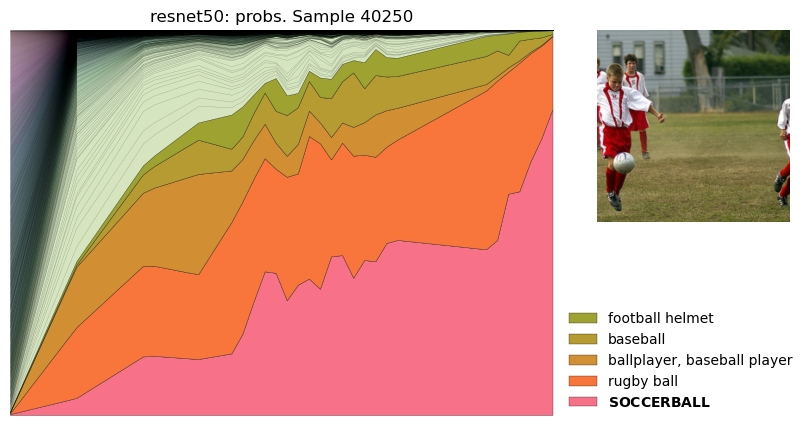

In [22]:
def stacksimple(i, x, prof, topk=5, ax=None):
    """
        i: index of image in dataset
        x: x-axis points
        prof: profile (NUM_LABELS, len(x))
        topk: number of "main" labels, for the legend.
    """
    true_label = ytest[i]
    areas = prof.sum(axis=1)
    areas[true_label] = +np.infty # force true label to be first
    ind = np.argsort(areas)[::-1] # sort labels according to their integrals

    label_names = [classes[idx] if j < topk else '_nolegend_' for j, idx in enumerate(ind)]
    if ax is None:
        f, ax = plt.subplots(figsize=(7, 5))
        # f, ax = plt.subplots(figsize=(3, 2))
    
    # colors = sns.color_palette('muted')[:topk] # first k colors: by palette
    # cm = sns.color_palette('rainbow', as_cmap=True)
    # fix_alpha = lambda c : tuple(c[:3] + (0.3,))
    # colors += [fix_alpha(cm(v)) for v in np.linspace(0, 1,len(ind)-topk)]
    
    cp = 0.3 # fraction of color space to take up with topk
    c1, c2 = np.linspace(0, cp, topk, endpoint=False), np.linspace(cp, 1, len(ind)-topk)
    fix_alpha = lambda c : tuple(c[:3] + (0.3,))
    cm = sns.color_palette('husl', as_cmap=True)
    colors = [cm(v) for v in c1] + [fix_alpha(cm(v)) for v in c2]
    
    stacks = ax.stackplot(x, prof[ind], labels=label_names, colors=colors)
    
    for s in stacks: #stacks[topk:]:
        s.set_edgecolor((0,0,0, 0.2))
        s.set_linewidth(0.2)

    for s in stacks[:topk]:
        s.set_edgecolor((0,0,0, 0.7))
        s.set_linewidth(0.3)
    
    handles, labels = ax.get_legend_handles_labels()
    labels[0] = "$\\bf{" + labels[0].upper().replace('_', '\ ') + "}$"
    labels = list(map(lambda e : e.replace('_', ' '), labels))
    handles, labels = handles[::-1], labels[::-1] # flip order
    
    ax.legend(handles, labels, bbox_to_anchor=(1.02, 0), loc='lower left', borderaxespad=0, frameon=False)
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(0, 1)
    ax.set_axis_off()  
    sns.despine()
    
    ax2 = ax.inset_axes([1.01, 0.5, 0.5, 0.5], aspect='equal')
    ax2.set_axis_off()
    ax2.imshow(dataset[i][0])
    
    return ax.figure


def std_single(Gi, x, gridpts, t="probs", smooth=False, sigma=2.0):
    """
        Return a "standard form" for the stackplots.
        Gi : (NUM_LABELS, NUM_CHECKPOINTS)
        x : the input x-axis (of Gi)
        gridpts : the output x-axis (to standardize wrt)
    """
    xx = gridpts
    res = []
    for j, y in enumerate(Gi):
        # linearly interpolate the curve on uniform grid
        f = interp1d(x, y, kind='linear')
        yy = f(xx)
        if smooth:
            yy = gaussian_filter1d(yy, sigma=sigma) # note that this doesn't mess up the probability simplex
        res.append(yy)
    return np.array(res)


## parameters
t = 'probs'
smooth = True
gridpts = 50 # num pts on x-axis

## generate plot
xkey = 'x'
x = G[xkey]

xx = np.linspace(x.min(), x.max(), gridpts) # output x-axis

i = rng.choice(range(NUM_SAMPLES)) # random image index
sns.reset_defaults()
mpl.rcParams['font.family'] = 'sans-serif'

# yy = G[t][i]

yy = std_single(G[t][i], x, gridpts=xx, t=t, smooth=False) ## standardize (uniform x-axis)
    
f = stacksimple(i, xx, yy) # the actual plot
f.axes[0].set_title(f'{gname}: {t}. Sample {i}');
f

In [21]:
outfname = f'../processed/imagenet/resnet50/resnet50_{dname}.npz'
print('saving to:', outfname)
with open(outfname, 'wb') as f:
    np.savez(f, **G)

saving to: ../processed/imagenet/resnet50/resnet50_imagenet_sketch.npz
